**Import libs**

In [1]:
%matplotlib inline

import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pl

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

from root_numpy import root2array, rec2array, array2root

Welcome to JupyROOT 6.24/02


**Prepare dataset**

In [3]:
branch_names = """lepton pT, jet 1 b-tag, jet 2 b-tag, jet 3 b-tag, jet 4 b-tag""".split(",")
branch_names = [c.strip() for c in branch_names]
branch_names = (b.replace(" ", "_") for b in branch_names)
branch_names = list(b.replace("-", "_") for b in branch_names)

signal = root2array("./HIGGSsignal.root",
                    "tree",
                    branch_names)
signal = rec2array(signal)

backgr = root2array("./HIGGSbackground.root",
                    "tree",
                    branch_names)
backgr = rec2array(backgr)

X = np.concatenate((signal, backgr))
y = np.concatenate((np.ones(signal.shape[0]), np.zeros(backgr.shape[0])))

**Train BDT**

In [4]:
X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.2, random_state=42)
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev, test_size=0.2, random_state=492)

dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.05, random_state=True)
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)

bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         min_samples_leaf=0.05,
                                                         random_state=True),
                   learning_rate=0.5, n_estimators=800)

BDT info

In [17]:
bdt.feature_importances_

array([0.58321923, 0.12532797, 0.10575265, 0.10367268, 0.08202748])

**Performance checks**

In [6]:
print("On testing sample:")
y_predicted = bdt.predict(X_test)
print(classification_report(y_test, y_predicted, target_names=["background", "signal"]))
print("Area under ROC curve: %.4f"%(roc_auc_score(y_test, bdt.decision_function(X_test))))


print("On training sample:")
y_predicted = bdt.predict(X_train)
print(classification_report(y_train, y_predicted, target_names=["background", "signal"]))
print("Area under ROC curve: %.4f"%(roc_auc_score(y_train, bdt.decision_function(X_train))))


On testing sample:
              precision    recall  f1-score   support

  background       0.55      0.40      0.46    104033
      signal       0.57      0.71      0.63    117067

    accuracy                           0.56    221100
   macro avg       0.56      0.56      0.55    221100
weighted avg       0.56      0.56      0.55    221100

Area under ROC curve: 0.5834
On training sample:
              precision    recall  f1-score   support

  background       0.56      0.40      0.47    210925
      signal       0.57      0.72      0.64    237975

    accuracy                           0.57    448900
   macro avg       0.57      0.56      0.55    448900
weighted avg       0.57      0.57      0.56    448900

Area under ROC curve: 0.5881


**ROC curve**

ROC curve on testing sample:


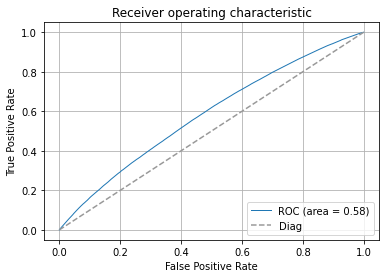

In [7]:
print("ROC curve on testing sample:")
from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Diag')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()
plot.savefig('roc.png')

**BDT learning curve**

{'algorithm': 'SAMME', 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 3, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 0.05, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__random_state': True, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.05, random_state=True), 'learning_rate': 0.5, 'n_estimators': 800, 'random_state': None}


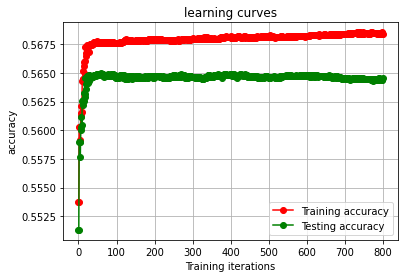

<Figure size 432x288 with 0 Axes>

In [10]:
print(bdt.get_params())

train_predictions = bdt.staged_predict(X_train)
test_predictions = bdt.staged_predict(X_test)

scores_test = []
scores_train = []
for i in test_predictions:
    scores_test.append(accuracy_score(i,y_test))
for i in train_predictions:
    scores_train.append(accuracy_score(i,y_train))

plt.figure()
plt.title("learning curves")
plt.xlabel("Training iterations")
plt.ylabel("accuracy")
plt.grid()
plt.plot(range(0,800,1), scores_train, 'o-', color="r",label="Training accuracy")
plt.plot(range(0,800,1), scores_test, 'o-', color="g",label="Testing accuracy")
plt.legend(loc="best")
plt.show()
plt.savefig('learning_curve.png')

**Overtraining Check**

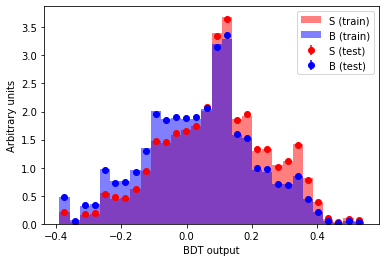

In [25]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)

    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    plt.show()
    plt.savefig('bdt_dist.png')

compare_train_test(bdt, X_train, y_train, X_test, y_test)

**Correlation Plots**

/var/folders/2j/rz3m9cgd6n3_26t7bsh_2h_c0000gn/T/ipykernel_3370/4023543111.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  correlations(df[bg].drop('y', 1), 'bkg')
/var/folders/2j/rz3m9cgd6n3_26t7bsh_2h_c0000gn/T/ipykernel_3370/4023543111.py:50: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  correlations(df[sig].drop('y', 1), 'sig')


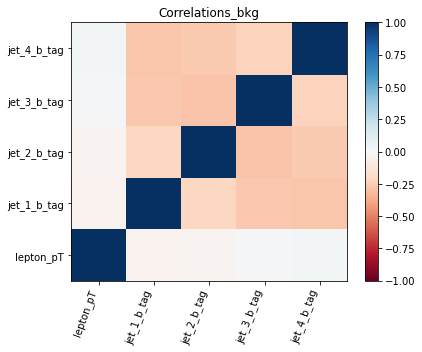

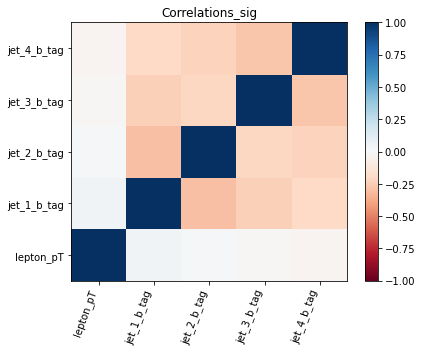

In [37]:
import pandas.core.common as com
from pandas.core.index import Index

from pandas.plotting import scatter_matrix


# Create a pandas DataFrame for our data
# this provides many convenience functions
# for exploring your dataset
# need to reshape y so it is a 2D array with one column
df = pd.DataFrame(np.hstack((X, y.reshape(y.shape[0], -1))),
                  columns=branch_names+['y'])


bg = df.y < 0.5
sig = df.y > 0.5

def correlations(data, extra_str, **kwds):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = data.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(6,5))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title("Correlations_"+extra_str)

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()
    
# remove the y column from the correlation matrix
# after using it to select background and signal
correlations(df[bg].drop('y', 1), 'bkg')
correlations(df[sig].drop('y', 1), 'sig')

**Pickle the output training data**

In [29]:
pl.dump(bdt, open("BDTAdaBoost.pk","wb"))

**Saving Classifier to Root Tree**

In [30]:
y_predicted = bdt.decision_function(X)
y_predicted.dtype = [('y', np.float64)]

array2root(y_predicted, "test-prediction.root", "BDToutput")

**Extra: load trained BDT and apply to input root data**

In [ ]:
branchlist=branch_names
treename="tree"
infilename='./datahist.root'
outfilename='./datahist_newMVA.root'
cutselection=''

inputpicklefile="BDTAdaBoost.pk"

X_in = root2array(infilename, treename, branches=branchlist, selection=cutselection)
bdt = pl.load(open(inputpicklefile,"rb"))
BDT_out = bdt.decision_function(pd.DataFrame(X_in))
BDT_out.dtype = [('BDToutput', np.float64)]
array2root(MVA_out, outfilename, "BDToutput")

In [19]:
a1d=np.array([5.22174e-12, 7.04852e-10, 3.49584e-08, 7.78029e-07, 9.11847e-06, 6.39666e-05, 0.000297587, 0.000996661,
       0.00256618,  0.00535396,  0.00944073,  0.0145521,   0.020145,    0.0255936,   0.0303632,   0.0341078,
       0.0366849,   0.0381183,   0.0385392,   0.0381327,   0.0370956,   0.0356113,   0.0338366,   0.0318978,
       0.029891,    0.0278866,   0.0259336,   0.0240643,   0.0222981,   0.0206453,   0.0191097,   0.0176902,
       0.0163832,   0.0151829,   0.0140826,   0.0130752,   0.0121533,   0.01131,     0.0105382,   0.00983178,
       0.00918467,  0.00859143,  0.00804709,  0.0075471,   0.00708733,  0.00666406,  0.00627393,  0.00591389,
       0.00558122,  0.00527344,  0.00498834,  0.00472392,  0.00447837,  0.00425007,  0.00403754,  0.00383947,
       0.00365465,  0.00348199,  0.00332052,  0.00316934,  0.00302764,  0.0028947,   0.00276983,  0.00265242,
       0.00254193,  0.00243785,  0.00233971,  0.00224709,  0.0021596,   0.00207687,  0.0019986,   0.00192447,
       0.00185421,  0.00178756,  0.0017243,   0.00166419,  0.00160705,  0.00155268,  0.00150093,  0.00145162,
       0.00140461,  0.00135976,  0.00131696,  0.00127607,  0.00123699,  0.00119962,  0.00116386,  0.00112963,
       0.00109683,  0.0010654,   0.00103526,  0.00100634,  0.000978578, 0.000951917, 0.000926299, 0.000901672,
       0.000877987, 0.000855198, 0.00083326,  0.000812133, 0.000791778, 0.000772159, 0.000753242, 0.000734994,
       0.000717384, 0.000700385, 0.000683967, 0.000668107, 0.000652779, 0.00063796,  0.000623629, 0.000609764,
       0.000596346, 0.000583356, 0.000570777, 0.000558592, 0.000546785, 0.00053534,  0.000524243, 0.000513481,
       0.00050304,  0.000492907, 0.000483072, 0.000473523, 0.000464248, 0.000455238, 0.000446483, 0.000437974,
       0.0004297,   0.000421655, 0.00041383,  0.000406216, 0.000398807, 0.000391595, 0.000384574, 0.000377736,
       0.000371076, 0.000364588, 0.000358266, 0.000352104, 0.000346097, 0.00034024,  0.000334528, 0.000328956,
       0.00032352,  0.000318216, 0.000313039, 0.000307986, 0.000303052, 0.000298234, 0.000293528, 0.000288931,
       0.000284439, 0.00028005,  0.000275761, 0.000271567, 0.000267468, 0.000263459, 0.000259538, 0.000255703,
       0.000251951, 0.00024828,  0.000244688, 0.000241172, 0.00023773,  0.000234361, 0.000231061, 0.00022783,
       0.000224666, 0.000221566, 0.000218528, 0.000215553, 0.000212636, 0.000209778, 0.000206977, 0.00020423,
       0.000201537, 0.000198896, 0.000196307, 0.000193767, 0.000191275, 0.000188831, 0.000186432, 0.000184079,
       0.000181769, 0.000179502, 0.000177277, 0.000175092, 0.000172947, 0.000170841, 0.000168772, 0.000166741,
       0.000164745, 0.000162785, 0.000160859, 0.000158967, 0.000157108, 0.00015528,  0.000153484, 0.000151719,
       0.000149984, 0.000148278, 0.000146601, 0.000144951, 0.000143329, 0.000141734, 0.000140165, 0.000138622,
       0.000137104, 0.00013561,  0.000134141, 0.000132695, 0.000131272, 0.000129871, 0.000128493, 0.000127136,
       0.000125801, 0.000124486, 0.000123191, 0.000121917, 0.000120662, 0.000119426, 0.000118209, 0.00011701,
       0.000115829, 0.000114665, 0.000113519, 0.00011239,  0.000111278, 0.000110182, 0.000109102, 0.000108037,
       0.000106988, 0.000105954, 0.000104935, 0.00010393,  0.000102939, 0.000101963, 0.000101,    0.000100051,
       9.91146e-05, 9.81915e-05, 9.7281e-05,  9.63831e-05, 9.54975e-05, 9.46239e-05, 9.37621e-05, 9.2912e-05,
       9.20733e-05, 9.12458e-05])

In [33]:
a=np.sum(a1d[0:25])/np.sum(a1d[0:250])
a

0.49388245104626244

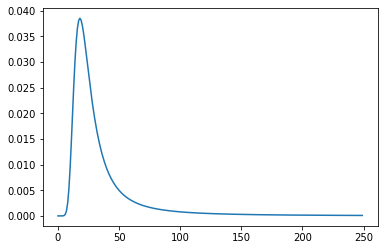

In [29]:
plt.plot(a1d)
plt.show()